In [47]:
#importing modules

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
import IPython.display as display
import os
import time
import functools

# Setting environment variable for TensorFlow Hub model loading
# os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Adjusting matplotlib settings
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

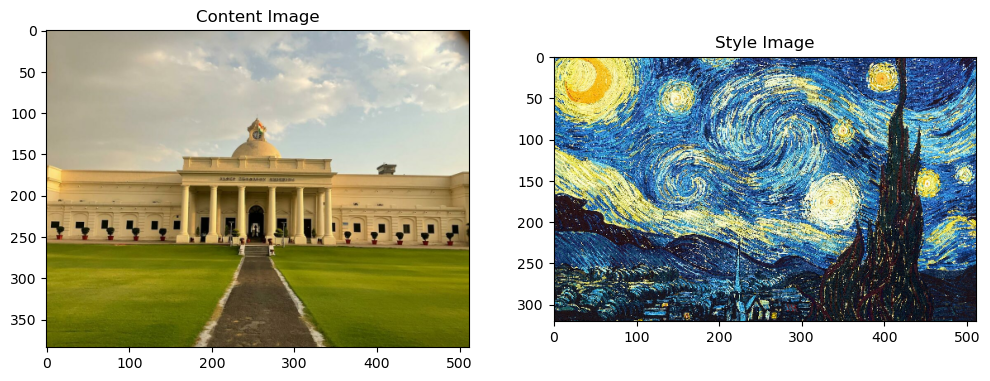

In [55]:
#converting the input tensor to image 
def convert_tensor_to_image(input_tensor):
    scaled_tensor = input_tensor * 255
    uint8_tensor = np.array(scaled_tensor, dtype=np.uint8)
    
    if np.ndim(uint8_tensor) > 3:
        assert uint8_tensor.shape[0] == 1
        uint8_tensor = uint8_tensor[0]
    
    image = PIL.Image.fromarray(uint8_tensor)
    return image

#defining the paths
# content_img_path = tf.keras.utils.get_file('cat2.jpg', 'C:/Users/Ansh Choudhary/OneDrive/Desktop/NST/contentt/cat2.jpg')
# style_img_path = tf.keras.utils.get_file('mona.jpg','C:/Users/Ansh Choudhary/OneDrive/Desktop/NST/contentt/mona.jpg')
# content_img_path = tf.keras.utils.get_file('kitten.jpg', 'https://storage.googleapis.com/cloud-ml-datasets/img/kitten.jpg')
# style_img_path = tf.keras.utils.get_file('starry_night.jpg', 'https://storage.googleapis.com/cloud-ml-datasets/img/starry_night.jpg')
content_img_path = 'IIT.jpeg'
style_img_path = 'vincent.jpg'

#function for loading and preprocessing image
def load_and_preprocess_image(image_path, target_size=512):
  image_data = tf.io.read_file(image_path)
  image_data = tf.image.decode_image(image_data, channels=3)
  image_data = tf.image.convert_image_dtype(image_data, tf.float32)
  
  image_shape = tf.cast(tf.shape(image_data)[:-1], tf.float32)
  longest_dimension = max(image_shape)
  scale_factor = target_size / longest_dimension
  new_image_shape = tf.cast(image_shape * scale_factor, tf.int32)
  resized_image = tf.image.resize(image_data, new_image_shape)
  preprocessed_image = resized_image[tf.newaxis, :]
  return preprocessed_image

#function for displaying the image
def display_image(img, caption=None):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)
  plt.imshow(img)
  if caption:
    plt.title(caption)

content_image = load_and_preprocess_image(content_img_path)
style_image = load_and_preprocess_image(style_img_path)

plt.subplot(1, 2, 1)
display_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
display_image(style_image, 'Style Image')

In [56]:
def preprocess_image(image, target_size=(224, 224)):
  x = tf.keras.applications.vgg19.preprocess_input(image * 255)
  x = tf.image.resize(x, target_size)
  return x


# def ltoad_vgg_model(include_top=False, weights='imagenet'):
#   reurn tf.keras.applications.VGG19(include_top=include_top, weights=weights)


def get_feature_extractor(layer_names):
  model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  model.trainable = False
  outputs = [model.get_layer(name).output for name in layer_names]
  return tf.keras.Model(inputs=model.inputs, outputs=outputs)


# Define content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

# Load pre-trained VGG models
# content_model = load_vgg_model(include_top=False)
# style_model = load_vgg_model(include_top=False)

# Extract features
content_features = get_feature_extractor(content_layers)(content_image * 255)
style_features = get_feature_extractor(style_layers)(style_image * 255)

#defining gram matrix
def calculate_gram_matrix(feature_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', feature_tensor, feature_tensor)
  num_locations = tf.cast(tf.size(feature_tensor) // feature_tensor.shape[-1], tf.float32)
  return result / num_locations



In [57]:
class StyleContentModel(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = get_feature_extractor(style_layers + content_layers)  # Reuse function
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Normalize input to range [0, 1]
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Extract features from the VGG model
    outputs = self.vgg(preprocessed_input)

    # Separate style and content layer outputs
    style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]

    # Calculate Gram matrices for style features
    style_outputs = [calculate_gram_matrix(style_output) for style_output in style_outputs]

    # Create dictionaries for content and style features
    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

#running gd
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

#clipping between 0 and 1 since it is a float image
def clipping(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#applying an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4



In [58]:
def calculate_style_content_loss(feature_outputs):
  style_outputs = feature_outputs['style']
  content_outputs = feature_outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  total_loss = style_loss + content_loss
  return total_loss

@tf.function
def perform_train_step(img):
  with tf.GradientTape() as tape:
    outputs = extractor(img)
    loss = calculate_style_content_loss(outputs)

  gradient = tape.gradient(loss, img)
  optimizer.apply_gradients([(gradient, img)])
  image.assign(clipping(img))
  return loss


Train step: 300
Time taken is 11.7


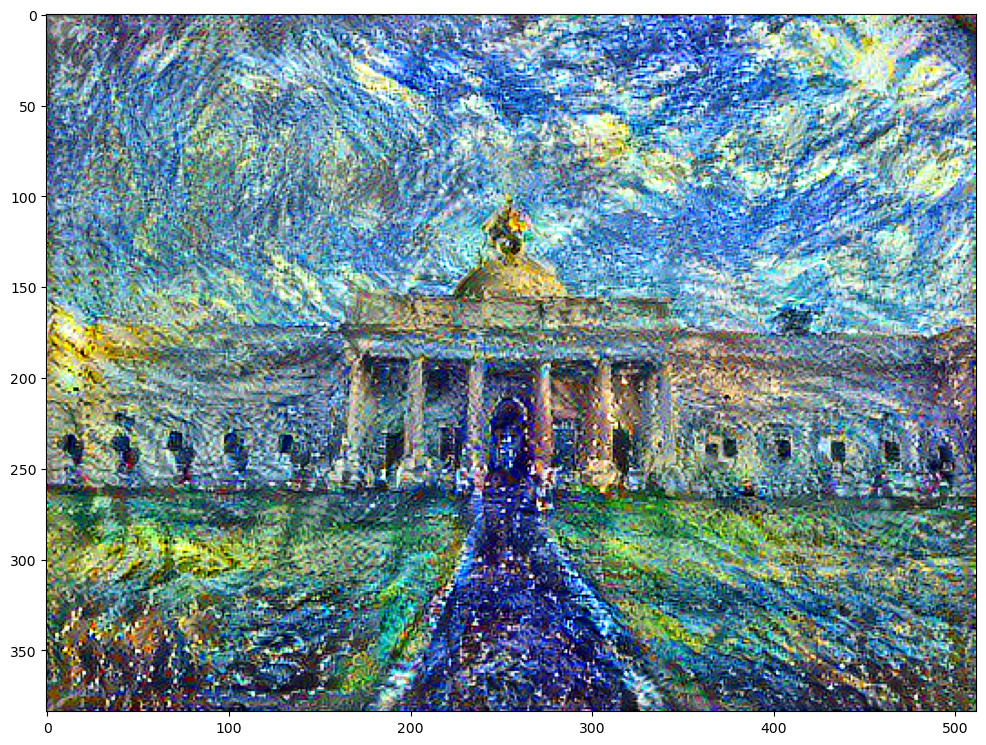

In [61]:
# perform_train_step(image)
# perform_train_step(image)
# perform_train_step(image)
# display_image(image)

#perform a longer optimization
start = time.time()
epochs = 10
steps_in_each_epochs = 30
step = 0
for epoch in range(epochs):
    for step_epoch in range(steps_in_each_epochs):
        step = step + 1
        perform_train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display_image(image)
    print("Train step: {}".format(step))
end = time.time()
print("Time taken is {:.1f}".format((end - start)/60))
